<a href="https://colab.research.google.com/github/anjay1101/Kaggle/blob/master/Kaggle_Real_Or_Not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle Real or Not Starting NLP Competition

Overview

1. Set up 
2. Exploration
2. Sklearn Naive Bayes model (0.83 accuracy)
3. Sklearn Random Forest model
4. Fastai classif model only (0.76 accuracy)
5. Fastai LM and classif model (0.79 accuracy)

In [0]:
from fastai.text import *
from fastai import *
import pandas as pd
import numpy as np 
import os

### **Set Up**

In [0]:
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab"


In [0]:
os.chdir("/content/drive/My Drive/Colab/Data/Real_Or_Not")

In [0]:
#! kaggle competitions download nlp-getting-started 

In [4]:
df = pd.read_csv("train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### **Data Exploration**

* A little under half of tweets are classified as not real 
* Almost all tweets have a *keyword*
* About 2/3rds of tweets have a *location*
* Each of the 221 unique keywords appears with about 30-35 tweets
* Over half of locations are unique, so they may give less information


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
print('label average ', df['target'].mean()*100, ' percent')

label average  42.96597924602653  percent


In [18]:
print('number of NaNs for keywords ', df['keyword'].isnull().sum())
print('number of keywords ', (df.shape[0]-df['keyword'].isnull().sum()))
print('\nnumber of NaNs for location ', df['location'].isnull().sum())
print('number of locations ', (df.shape[0]-df['location'].isnull().sum()))

number of NaNs for keywords  61
number of keywords  7552

number of NaNs for location  2533
number of locations  5080


In [26]:
print('number of unique keywords', df['keyword'].unique().shape[0]-1)

number of unique keywords 221


In [0]:
for each in df['keyword'].unique():
  c = 0; 
  for word in df['keyword']:
    if (word==each): 
      c = c + 1
  print("keyword: ", each, " count: ", c)

In [51]:
print('number of unique locations', df['location'].unique().shape[0]-1)

number of unique locations 3341


### **SkLearn Naive Bayes**
- Preprocess using TFIDF or CountVectorizer 
- Feature selection using Mutual Info Gain
* 0.83 accuracy
* 0.78 F-Score

In [0]:
from sklearn.naive_bayes import *

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

In [0]:
# Pre-process for counts
vect = CountVectorizer()
vect_tsfm = vect.fit(train['text'])
X_vect = vect_tsfm.transform(train['text'])
test_vect = vect_tsfm.transform(test['text'])

In [0]:
y_train = train['target']

In [0]:
def mutual_info_select(X_train,y_train,X_test,k):
    selector = SelectKBest(mutual_info_classif, k=min(k, X_train.shape[1]))
    selector.fit(X_train,y_train)
    return selector.transform(X_train),selector.transform(X_test)

In [0]:
#Feature selection
X_train_vect,X_test_vect = mutual_info_select(X_vect,y_train,test_vect,5000)

In [0]:
#Train test split
X_train_vect, X_val, y_train, y_val = train_test_split(X_train_vect,y_train,test_size=0.2,random_state=42)


In [77]:
#Model building
mnb = MultinomialNB()
mnb_model = mnb.fit(X_train_vect, y_train)
y_pred = mnb_model.predict(X_val)
print("train accuracy ", mnb_model.score(X_train_vect,y_train))
print("\nf1 " , f1_score(y_val, y_pred))
print("accuracy ", accuracy_score(y_val,y_pred)) 

train accuracy  0.8637110016420362

f1  0.7882256745707277
accuracy  0.8299409061063691


In [0]:
#Predictions
pred = mnb_model.predict(X_test_vect)

In [0]:
preds = pd.DataFrame(pred)
preds.to_csv('submission_3.csv',sep=',',index=False)

### Fastai classif model only 
* 0.76 accuracy
* 0.57 F-Score (due to error in predictions)

In [0]:
data = (TextList.from_csv("", 'train.csv', cols='text')
                .split_by_rand_pct()
                .label_from_df(cols=4)
                .databunch(bs=32))

In [0]:
data.show_batch() #the automatic processing seems to get rid of a lot of works

In [0]:
learn = text_classifier_learner(data, AWD_LSTM, drop_mult=0.8)

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


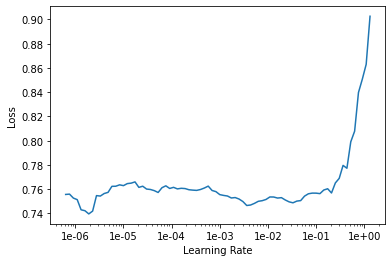

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 4e-2, moms=(0.8,0.7))

In [0]:
learn.save('first')

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.669537,0.654932,0.606439,00:03


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.654746,0.633764,0.657687,00:04


In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.636308,0.600935,0.676741,00:06
1,0.608064,0.585109,0.706964,00:05


In [0]:
learn.save('0.70')

In [0]:
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.600655,0.606900,0.685283,00:05
1,0.595008,0.622944,0.662943,00:06
2,0.573874,0.526553,0.754271,00:06
3,0.559938,0.527642,0.756242,00:05
4,0.547793,0.553580,0.731932,00:05


In [0]:
learn.save('0.73')

In [0]:
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.543233,0.530673,0.754271,00:06
1,0.539557,0.521558,0.752300,00:05
2,0.543795,0.522062,0.745072,00:05
3,0.527655,0.504525,0.752300,00:05
4,0.514319,0.495714,0.780552,00:06
5,0.499831,0.534853,0.766754,00:06
6,0.490121,0.516031,0.764126,00:06
7,0.469805,0.519586,0.770696,00:06
8,0.463982,0.524910,0.764126,00:05
9,0.463949,0.530769,0.765440,00:05


In [0]:
learn.freeze()

In [0]:
learn.save('0.765')

In [0]:
learn.fit_one_cycle(10,slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.464886,0.541590,0.761498,00:02
1,0.471987,0.543289,0.763469,00:02
2,0.461715,0.558057,0.762155,00:02
3,0.460748,0.536251,0.764126,00:02
4,0.466402,0.519900,0.767411,00:02
5,0.454757,0.528360,0.768725,00:02
6,0.453938,0.524036,0.769382,00:02
7,0.459234,0.557809,0.760841,00:02
8,0.459401,0.528207,0.765440,00:02
9,0.461994,0.546001,0.762812,00:02


In [0]:
sample = pd.read_csv("sample_submission.csv")

In [0]:
sample.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [0]:
test = pd.read_csv('test.csv')

In [0]:
test.shape

(3263, 4)

In [0]:
for i in range(test.shape[0]):
  pred = data.classes[learn.predict(test['text'][2])[1]]
  test['text'][i] = pred;

In [0]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,1
1,2,NaN,NaN,1
2,3,NaN,NaN,1
3,9,NaN,NaN,0
4,11,NaN,NaN,0


In [0]:
test.to_csv('submission.csv',sep=',',index=False)

### Fstai LM and classif model
* 0.79 accuracy
* 0.57 F-Score (due to error in predictions)

In [0]:
#Implement LM to help 
bs=32
data_lm = (TextList.from_csv("",'train.csv', cols='text')
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))


In [0]:
data_lm.show_batch()

idx,text
0,# xxmaj alaska as smoke from # wildfires xxunk into a school xxbos # rockyfire xxmaj update = > xxmaj california xxmaj hwy . 20 closed in both xxunk due to xxmaj lake xxmaj county fire - # xxunk # wildfires xxbos # flood # disaster xxmaj heavy rain causes flash flooding of streets in xxmaj xxunk xxunk xxmaj colorado xxmaj springs areas xxbos i 'm on top of the
1,park xxmaj services xxmaj tonto xxmaj national xxmaj forest : xxmaj stop the xxmaj annihilation of the xxmaj salt xxmaj river xxmaj wild xxmaj horse ... http : / / t.co / xxunk m via @change xxbos xxunk xxmaj please check into xxmaj salt xxmaj river horses help stop the annihilation about to happen without xxunk more xxunk xxunk xxmaj thx xxbos xxmaj are souls xxunk xxunk ? http :
2,/ / t.co / xxunk xxbos [ xxunk ] xxmaj nashville xxmaj theater xxmaj attack : xxmaj will xxmaj gun xxmaj xxunk xxmaj now xxmaj demand xxunk xxunk http : / / t.co / xxunk # xxunk xxbos xxunk attack ? ? xxbos xxmaj my dog attacked me for my food # xxunk xxbos xxmaj cop injured in xxunk as militants attack xxmaj udhampur police post : xxmaj suspected militants
3,you xxbos xxmaj joe xxmaj xxunk : xxmaj this gel can make you stop bleeding xxunk http : / / t.co / xxunk # arizona # xxunk http : / / t.co / xxunk xxbos now my nose is bleeding . the last one was like 10 years ago xxbos xxunk i ca n't help it . xxmaj hope you 're ok . xxmaj text me if you need to
4,xxmaj purse xxmaj camera xxmaj bag xxmaj cross xxmaj body # xxunk \n \n $ xxunk ( 0 xxmaj xxunk ) \n xxup û _ http : / / t.co / xxunk xxbos genuine xxmaj leather man xxmaj bag xxmaj messenger xxunk xxunk mini 4 tablet case cross body air xxunk - xxmaj full reaû _ http : / / t.co / xxunk http : / / t.co


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


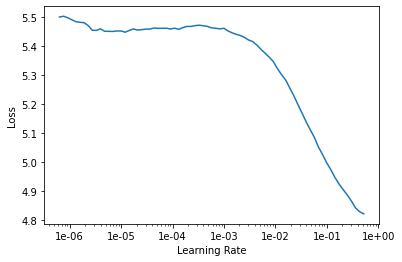

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(3, 9e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,10.058795,11.624722,0.218899,00:05
1,9.139543,5.483634,0.330308,00:05
2,5.717102,4.287123,0.367361,00:05


In [0]:
learn.save('first')


In [0]:
learn.unfreeze()

In [0]:
learn.load('first');

In [0]:
learn.fit_one_cycle(15, 1e-3, moms=(0.8,0.7))

In [0]:
learn.load('fine_tuned');

In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
data = (TextList.from_csv("", 'train.csv', cols='text',vocab=data_lm.vocab)
                .split_by_rand_pct()
                .label_from_df(cols=4)
                .databunch(bs=bs))

In [0]:
learn_cls = text_classifier_learner(data, AWD_LSTM, drop_mult=0.5);
learn_cls.load_encoder('fine_tuned_enc');


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


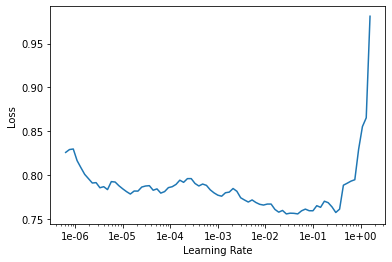

In [0]:
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.644995,0.573020,0.704336,00:03
1,0.619507,0.557393,0.715506,00:03


In [0]:
learn_cls.save('clf_1')

In [0]:
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.606493,0.547774,0.726675,00:04


In [0]:
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.578972,0.536179,0.730618,00:06
1,0.543998,0.483224,0.778581,00:06
2,0.495849,0.468439,0.789093,00:06


In [0]:
learn_cls.save('clf_3')

In [0]:
learn_cls.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.496678,0.489750,0.771353,00:06
1,0.475393,0.463520,0.789093,00:06
2,0.423891,0.477411,0.785151,00:06


In [0]:
learn_cls.unfreeze()
learn_cls.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.404641,0.475806,0.798949,00:08
1,0.422451,0.461832,0.790407,00:08
2,0.389247,0.479781,0.785808,00:08


In [0]:
learn_cls.load('clf_3')
learn_cls.freeze()
learn_cls.fit_one_cycle(3,slice(6e-4,5e-3),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.492618,0.469283,0.788436,00:03
1,0.494864,0.468572,0.791064,00:03
2,0.479886,0.464202,0.790407,00:03


In [0]:
learn_cls.save('best')

In [0]:
test = pd.read_csv('test.csv')

In [0]:
for i in range(test.shape[0]):
  pred = data.classes[learn_cls.predict(test['text'][2])[1]];
  test['text'][i] = pred;

test.to_csv('submission_2.csv',sep=',',index=False)

I still only got a score of 0.57 on the submission. 
The reasons I think include:
* Failing to use the non-text columns (ensemble method or OneHotEncoding) 
* Failing to split the data in a way that might be meaningful and avoid overfitting (not sure on how to do this)
* Over pre-processing (changing the fastai parameters)
* Not training the data quite right (messing around with parameters & doing some research)
* Possibly, making predictions wrong (checking that it is right by testing on training data) 
* The fastai NN isn't the best fit (adjust or use sk-learn)
* Not optimizing for F1 score, so go back and optimize for F1 instead
* **turns out this isn't working because it's predicting all 0's**